In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from epiweeks import Week
from datetime import datetime, timedelta
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
import numpy as np
from utils import timeseries_formatting, basic_formatting, dec_to_date, hpd, _toYearFraction
from dendropy import TreeList, Tree
import time
from scipy.signal import correlate, correlation_lags
import statsmodels.api as sm
from scipy.stats import pearsonr

prop = mpl.font_manager.FontProperties('Roboto')
mpl.rcParams['font.sans-serif'] = prop.get_name()
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.size']=16

COLOR = '#343434'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

# Supplemental figure 9-10: Transmission in San Diego results from reintroductions rather than persistent lineages
We calculate month over month lineage persistence to show that circulating lineages in San Diego are typically recently introduced, and support this claim using contact tracing data collected by the county.

Month over month persistent is calculated from the posterior distribution of trees generate from the `2021-08-30_fixed_eponential_discrete` beast run. Using the `PersistenceSummarizer` function of BEAST, we calculate for each month present in the tree the number of lineage circulating, which location state they are associated with, since what time point in the past they have maintained that state and how many sampled descendants they have. From this information, we calculate the proportion of San Diego lineages that where associated with each location state one month prior. Lineages which maintained a location state of San Diego, were identified as persistent, while all other San Diego lineages were deemed recently introduced.

In [2]:
ps = pd.read_csv( "../data/2022-11-17_exponential_fixed_discete.biweekly.summary.csv", parse_dates=["eval_time", "anc_time"] )
ps = ps.loc[ps["eval_state"]=="San Diego"]
#ps["eval_time"] = ps["eval_time"] + pd.offsets.MonthBegin(0)
#ps["anc_time"] = ps["anc_time"] + pd.offsets.MonthBegin(0)
ps.head()

,eval_time,anc_time,anc_state,eval_state,proportion,hpdl,hpdu
24,2022-10-01,2022-09-17,Rest of World,San Diego,0.233815,0.0,1.0
25,2022-10-01,2022-09-17,United States,San Diego,0.098748,0.0,1.0
26,2022-10-01,2022-09-17,Mexico,San Diego,0.003083,0.0,0.0
27,2022-10-01,2022-09-17,Los Angeles,San Diego,0.321195,0.0,1.0
28,2022-10-01,2022-09-17,San Diego,San Diego,0.337958,0.0,1.0


We plot the proportion of lineages circulating in San Diego that can be linked backed to the stated location two weeks prior. Not included in paper.

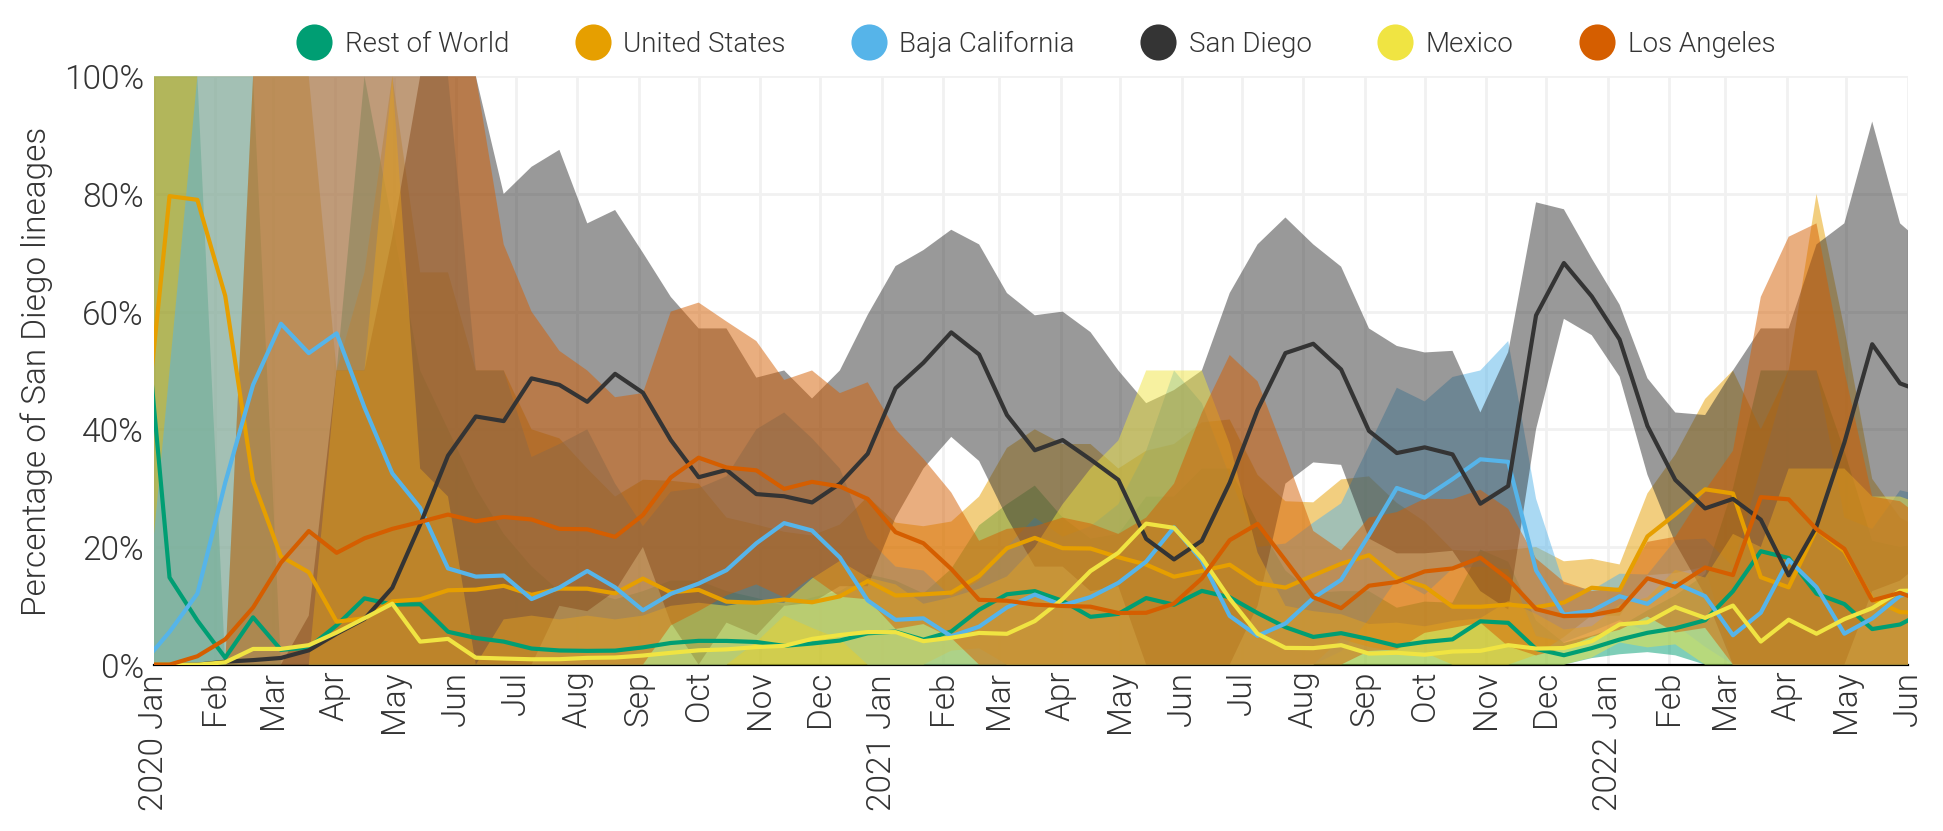

In [3]:
ps["anc_state"].unique()

color_dict = [
     ["Rest of World","#009E73"],
     ["United States","#E69F00"],
     ["Baja California","#56B4E9"],
     ["San Diego",COLOR],
     ["Mexico","#F0E442"],
     ["Los Angeles","#D55E00"]
]

leg = []
fig, ax = plt.subplots( dpi=200, figsize=(10,4.5) )
for loc, col in color_dict:
    plot_df = ps.loc[ps["anc_state"]==loc]
    ax.plot( "eval_time", "proportion", data=plot_df, color=col, zorder=9 )
    ax.fill_between( "eval_time", "hpdl", "hpdu", data=plot_df, color=col, alpha=0.5, zorder=8, linewidth=0 )
    leg.append( Line2D([0], [0], linestyle='none', marker='o', color=col, label=loc, markersize=12 ) )

ax.yaxis.set_major_formatter( PercentFormatter( 1, 0 ) )
basic_formatting(
    ax,
    which="both",
    spines=["bottom"],
    ylabel="Percentage of San Diego lineages",
    ylims=[0,1],
    xlims=[pd.to_datetime("2020-01-01"), pd.to_datetime("2022-06-01")]
)
timeseries_formatting( ax )

ax.legend( handletextpad=0.1, handles=leg, frameon=False, fontsize=10, ncol=6, loc="upper center", bbox_to_anchor=(0,0,1,1.12) )

plt.tight_layout()
plt.savefig( "../analyses/plots/figureX_lineage-persistence-san-diego.pdf" )
plt.show()

Below we plot Supplemental figure 9, the percentage of San Diego lineages that can be linked backed to a persistent lineages within San Diego two weeks prior. We also label waves of the epidemic in San Diego.

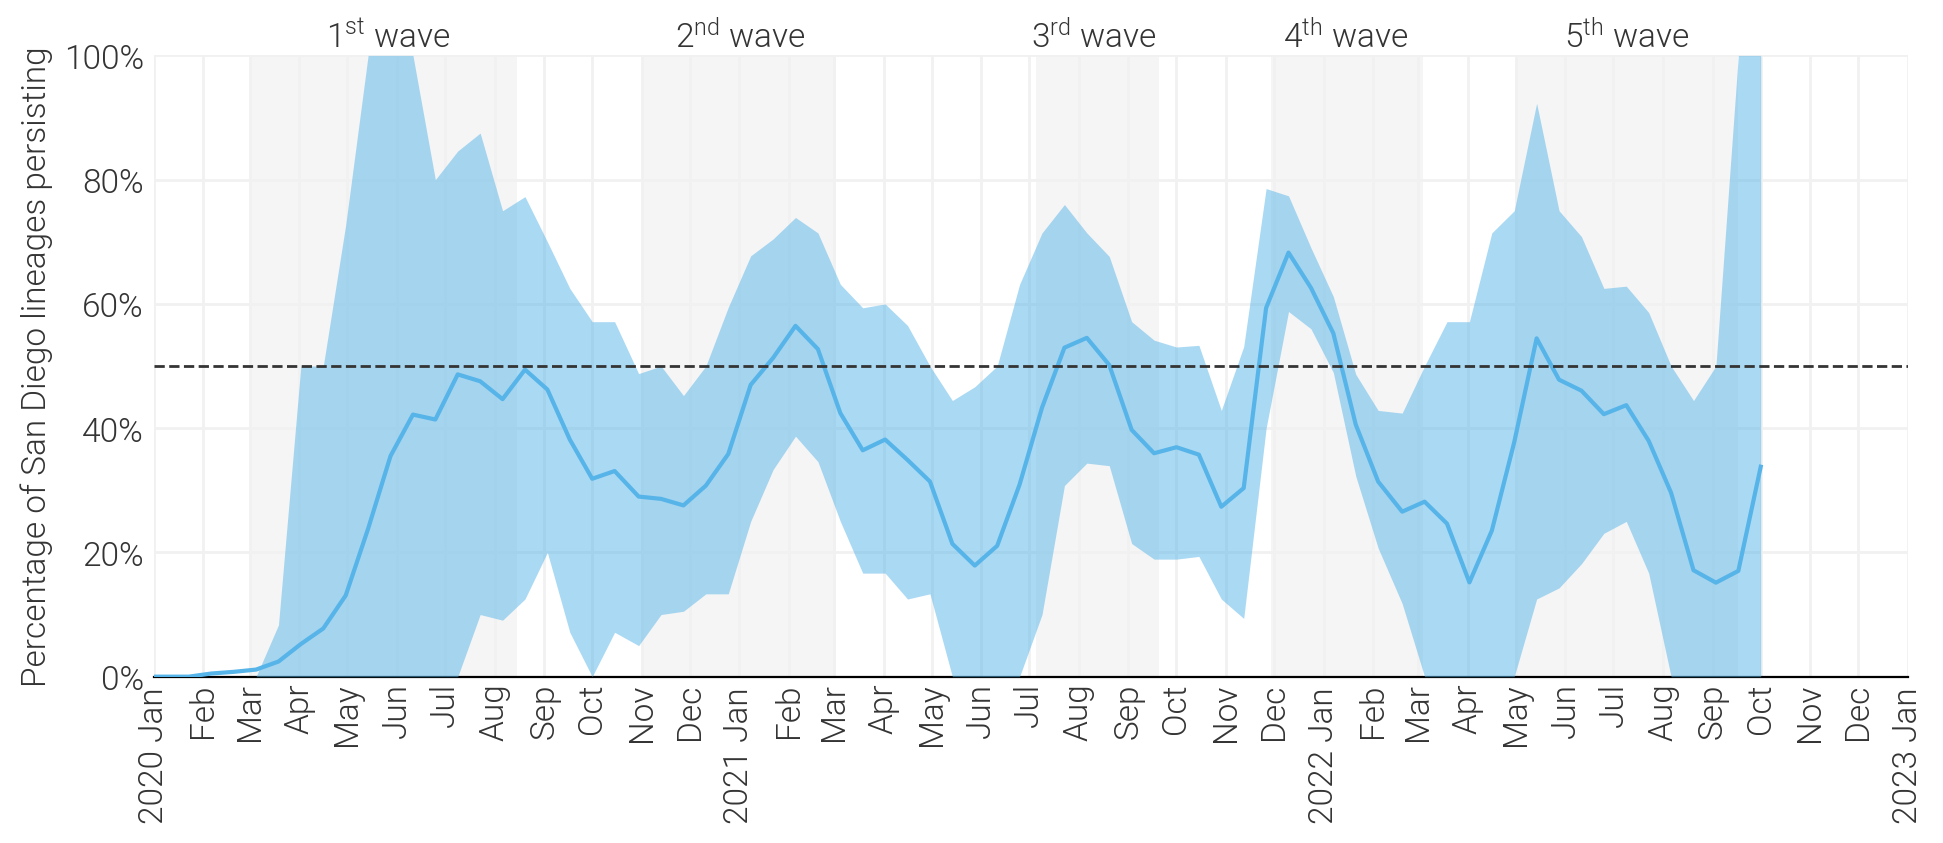

In [4]:
waves = [
    ("First wave", ["2020-08-15"]),
    ("First trough", ["2020-08-15", "2020-11-02"]),
    ("Second wave", ["2020-11-02", "2021-03-02"]),
    ("Second trough", ["2021-03-02", "2021-07-05"]),
    ("Third wave", ["2021-07-05", "2021-09-20"]),
    ("Third trough", ["2021-09-20", "2021-11-29"]),
    ("Fourth wave", ["2021-11-29", "2022-03-04"]),
    ("Fourth trough", ["2022-03-04", "2022-05-01"])
]


fig, ax = plt.subplots( dpi=200, figsize=(10,4.5) )
plot_df = ps.loc[ps["anc_state"]=="San Diego"]
ax.plot( "eval_time", "proportion", data=plot_df, color="#56B4E9", zorder=9 )
ax.fill_between( "eval_time", "hpdl", "hpdu", data=plot_df, color="#56B4E9", alpha=0.5, zorder=8, linewidth=0 )

ax.axvspan( "2020-03-01", "2020-08-15", zorder=0, color="#000000", alpha=0.04, linewidth=0 )
ax.annotate( "$\mathregular{1^{st}}$ wave", (pd.to_datetime( "2020-03-01" ), 1), (50,3), textcoords="offset points", ha="center", fontsize=12 )
ax.axvspan( "2020-11-02", "2021-03-02", zorder=0, color="#000000", alpha=0.04, linewidth=0 )
ax.annotate( "$\mathregular{2^{nd}}$ wave", (pd.to_datetime( "2020-11-02" ), 1), (35,3), textcoords="offset points", ha="center", fontsize=12 )
ax.axvspan( "2021-07-05", "2021-09-20", zorder=0, color="#000000", alpha=0.04, linewidth=0 )
ax.annotate("$\mathregular{3^{rd}}$ wave", ( pd.to_datetime("2021-07-05" ), 1), (21,3), textcoords="offset points", ha="center", fontsize=12 )
ax.axvspan( "2021-11-29", "2022-03-04", zorder=0, color="#000000", alpha=0.04, linewidth=0 )
ax.annotate( "$\mathregular{4^{th}}$ wave", (pd.to_datetime( "2021-11-29" ), 1), (27,3), textcoords="offset points", ha="center", fontsize=12 )
ax.axvspan( "2022-05-01", "2022-09-17", zorder=0, color="#000000", alpha=0.04, linewidth=0 )
ax.annotate( "$\mathregular{5^{th}}$ wave", (pd.to_datetime( "2022-05-01" ), 1), (40,3), textcoords="offset points", ha="center", fontsize=12 )

ax.axhline( 0.5, color=COLOR, linewidth=1, linestyle="dashed", zorder=10 )

ax.yaxis.set_major_formatter( PercentFormatter( 1, 0 ) )
basic_formatting(
    ax,
    which="both",
    spines=["bottom"],
    ylabel="Percentage of San Diego lineages persisting",
    ylims=[0,1],
    xlims=[pd.to_datetime("2020-01-01"), pd.to_datetime("2023-01-01")]
)

timeseries_formatting( ax )
plt.tight_layout()
plt.savefig( "../analyses/plots/figureS9_lineage-persistence-san-diego-only.pdf" )
plt.show()

# Contact tracing Data
There are quite large uncertainties in the persistence results, owning to uncertainty in discrete state analysis. We confirm our results using contact tracing data collected by San Diego County, which asked, among other questions, whether there was travel within the US, Mexico, or internationally in the 14 days prior to symptom onset or positive test result (if infection is asymptomatic).

In [5]:
views = pd.read_csv( "../data/sdcphl_case_tracing.csv" )
dates = views["Year"] * 100 + views["Disease Week"]
views["week"] = pd.to_datetime( dates.astype(str) + "0", format='%Y%W%w' )
views["month"] = views["week"].astype( "datetime64[M]" )
views = views.drop( columns=["Year", "Disease Week"] )
views = views.rename( columns={"Total Number of Cases (Interviewed Only)" : "cases_interviewed"} )

#views["percent_domestic"] = views["Domestic"] / views["cases_interviewed"]
#views["percent_mexico"] = views["Mexico"] / views["cases_interviewed"]
#views["percent_international"] = views["International"] / views["cases_interviewed"]
#views["percent_travel"] = (views["Domestic"] + views["Mexico"] + views["International"]) / views["cases_interviewed"]

views = views.sort_values( "week")
views

,Domestic,Mexico,International,cases_interviewed,week,month
0,0,6,0,213,2020-06-14,2020-06-01
1,40,60,0,841,2020-06-21,2020-06-01
2,153,84,0,1511,2020-06-28,2020-06-01
3,270,85,1,2288,2020-07-05,2020-07-01
4,301,92,2,2609,2020-07-12,2020-07-01
...,...,...,...,...,...,...
87,126,57,8,2314,2022-02-06,2022-02-01
88,130,66,9,1993,2022-02-13,2022-02-01
89,136,48,9,1934,2022-02-20,2022-02-01
90,103,36,6,1256,2022-02-27,2022-02-01


To estimate uncertainty in the data, we calculate confidence intervals by bootstrapping intervews 1000 times.

In [6]:
def generate_list_from_values( entry ):
    entry_none = entry["cases_interviewed"] - entry["Domestic"] - entry["Mexico"] - entry["International"]
    return_list = (["Domestic"] * entry["Domestic"]) + (["Mexico"] * entry["Mexico"]) + (["International"] * entry["International"]) + (["None"] * entry_none)
    return return_list

get_low = lambda x: x.quantile( 0.025 )
get_high = lambda x: x.quantile( 0.975 )

test = views.iloc[2]
estimates = {
    "date" : [],
    "source" : [],
    "median" : [],
    "upper" : [],
    "lower" : [],
}
for _, row in views.iterrows():
    test_list = generate_list_from_values( row )
    results = []
    for i in range( 1000 ):
        boot_entry = np.random.choice( test_list, len( test_list ), replace=True )
        boot_results = pd.value_counts( boot_entry )
        boot_results = boot_results / boot_results.sum()
        results.append( boot_results )
    results = pd.DataFrame( results )

    for col in ["Domestic", "International", "Mexico", "Total"]:

        estimates["date"].append( row["week"] )
        estimates["source"].append( col )
        if col == "Total":
            column = 1 - results["None"]
            estimates["median"].append( column.quantile(0.5) )
            estimates["upper"].append( column.quantile(0.975) )
            estimates["lower"].append( column.quantile(0.025) )
        elif col in results:
            values = results.agg(
                value_median = ( col, "median" ),
                value_lower = ( col, get_low ),
                value_upper = ( col, get_high )
            )
            estimates["median"].append( values[col]["value_median" ])
            estimates["upper"].append( values[col]["value_upper" ])
            estimates["lower"].append( values[col]["value_lower" ])
        else:
            estimates["median"].append( 0 )
            estimates["upper"].append( 0 )
            estimates["lower"].append( 0 )
estimates = pd.DataFrame( estimates )
estimates.head()

,date,source,median,upper,lower
0,2020-06-14,Domestic,0.000000,0.000000,0.000000
1,2020-06-14,International,0.000000,0.000000,0.000000
2,2020-06-14,Mexico,0.028169,0.051643,0.009390
3,2020-06-14,Total,0.028169,0.051643,0.009390
4,2020-06-21,Domestic,0.047562,0.061831,0.034483


Here we plot the percentage of cases that can be linked to travel within the US, Mexico, or internationally. This generates supplemental figure 6A.

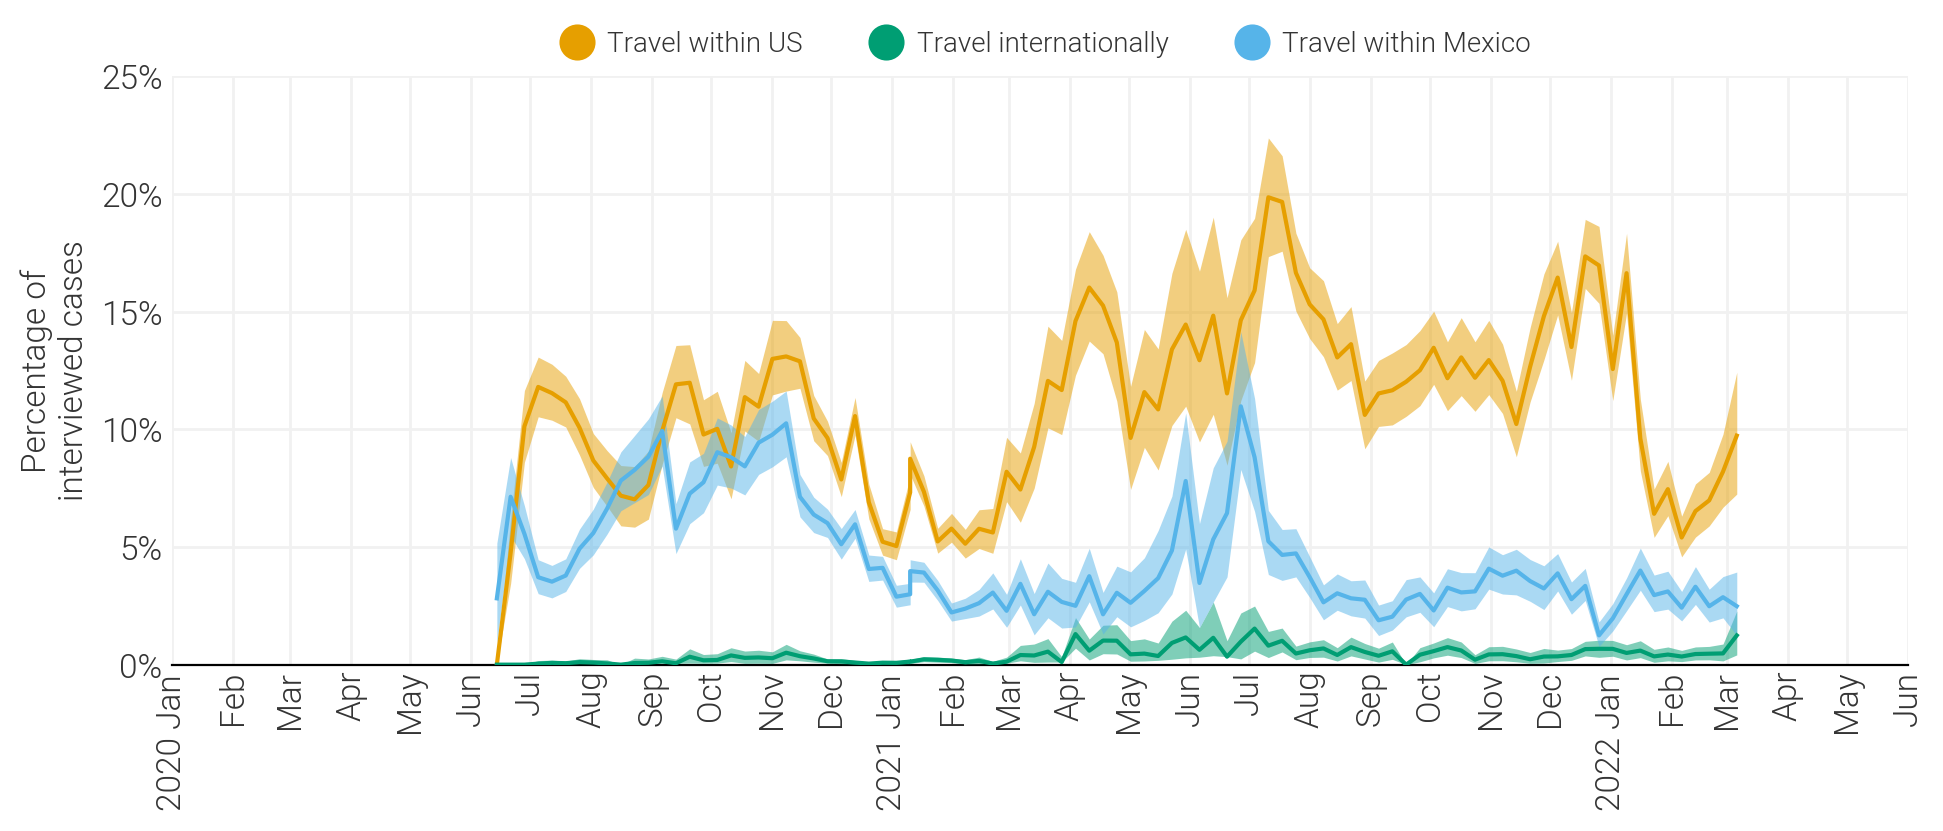

In [7]:
color_dict = [
    ["Domestic","#E69F00"],
    ["International","#009E73"],
    ["Mexico","#56B4E9"]
]

name_dic = {
    "International" : "Travel internationally",
    "Domestic" : "Travel within US",
    "Mexico" : "Travel within Mexico"
}

leg = []
fig, ax = plt.subplots( dpi=200, figsize=(10,4.5) )
for loc, col in color_dict:
    plot_df = estimates.loc[estimates["source"]==loc]
    ax.plot( "date", "median", data=plot_df, color=col, zorder=9 )
    ax.fill_between( "date", "upper", "lower", data=plot_df, color=col, alpha=0.5, zorder=8, linewidth=0 )
    leg.append( Line2D([0], [0], linestyle='none', marker='o', color=col, label=name_dic[loc], markersize=12 ) )

ax.yaxis.set_major_formatter( PercentFormatter( 1, 0 ) )
basic_formatting(
    ax,
    which="both",
    spines=["bottom"],
    ylabel="Percentage of\ninterviewed cases",
    ylims=[0,0.25],
    xlims=[pd.to_datetime("2020-01-01"), pd.to_datetime("2022-06-01")]
)
timeseries_formatting( ax )

ax.legend( handletextpad=0.1, handles=leg, frameon=False, fontsize=10, ncol=6, loc="upper center", bbox_to_anchor=(0,0,1,1.12) )

plt.tight_layout()
plt.savefig( "../analyses/plots/figureS10_contact-tracing-travel-san-diego.pdf" )
plt.show()

We're specifically using this data to support findings from our phylogeographic analysis which found that introductions had relatively less impact on local cases during periods of high incidence. Here we load reported cases in San Diego.

In [8]:
sd = pd.read_csv( "../analyses/estimated-importation-risk/back-calculated-infections.csv", usecols=["date", "location", "cases"], parse_dates=["date"] )
sd = sd.loc[sd["location"]=="San Diego County"]
sd["cases"] = sd["cases"].rolling( 7, min_periods=1 ).mean()
sd["week"] = sd["date"].apply( lambda x: Week.fromdate( x ).startdate() )
sd = sd.groupby( "week" )["cases"].sum().reset_index()
sd["week"] = pd.to_datetime( sd["week"] )

total = estimates.loc[estimates['source']=="Total"].merge( sd, left_on=["date"], right_on=["week"] )
total

,date,source,median,upper,lower,week,cases
0,2020-06-14,Total,0.028169,0.051643,0.009390,2020-06-14,1066.571429
1,2020-06-21,Total,0.118906,0.141498,0.097503,2020-06-21,1778.285714
2,2020-06-28,Total,0.156850,0.174719,0.138981,2020-06-28,2999.142857
3,2020-07-05,Total,0.155594,0.170455,0.142035,2020-07-05,3254.000000
4,2020-07-12,Total,0.151399,0.165964,0.137601,2020-07-12,3469.285714
...,...,...,...,...,...,...,...
87,2022-02-06,Total,0.082541,0.093345,0.071737,2022-02-06,19754.571429
88,2022-02-13,Total,0.102860,0.116420,0.089313,2022-02-13,11971.714286
89,2022-02-20,Total,0.099276,0.113237,0.086350,2022-02-20,7999.000000
90,2022-02-27,Total,0.115446,0.132962,0.097134,2022-02-27,6247.571429


We plot the percentage of cases that can be linked to travel compared to the reported cases and San Diego. We determine the correlation between them using Pearson correlation coefficient. This generates supplemental figure 10B.

PearsonRResult(statistic=-0.23203513653414423, pvalue=0.02603812846927109)
ConfidenceInterval(low=-0.4170331110309487, high=-0.028575792333257452)


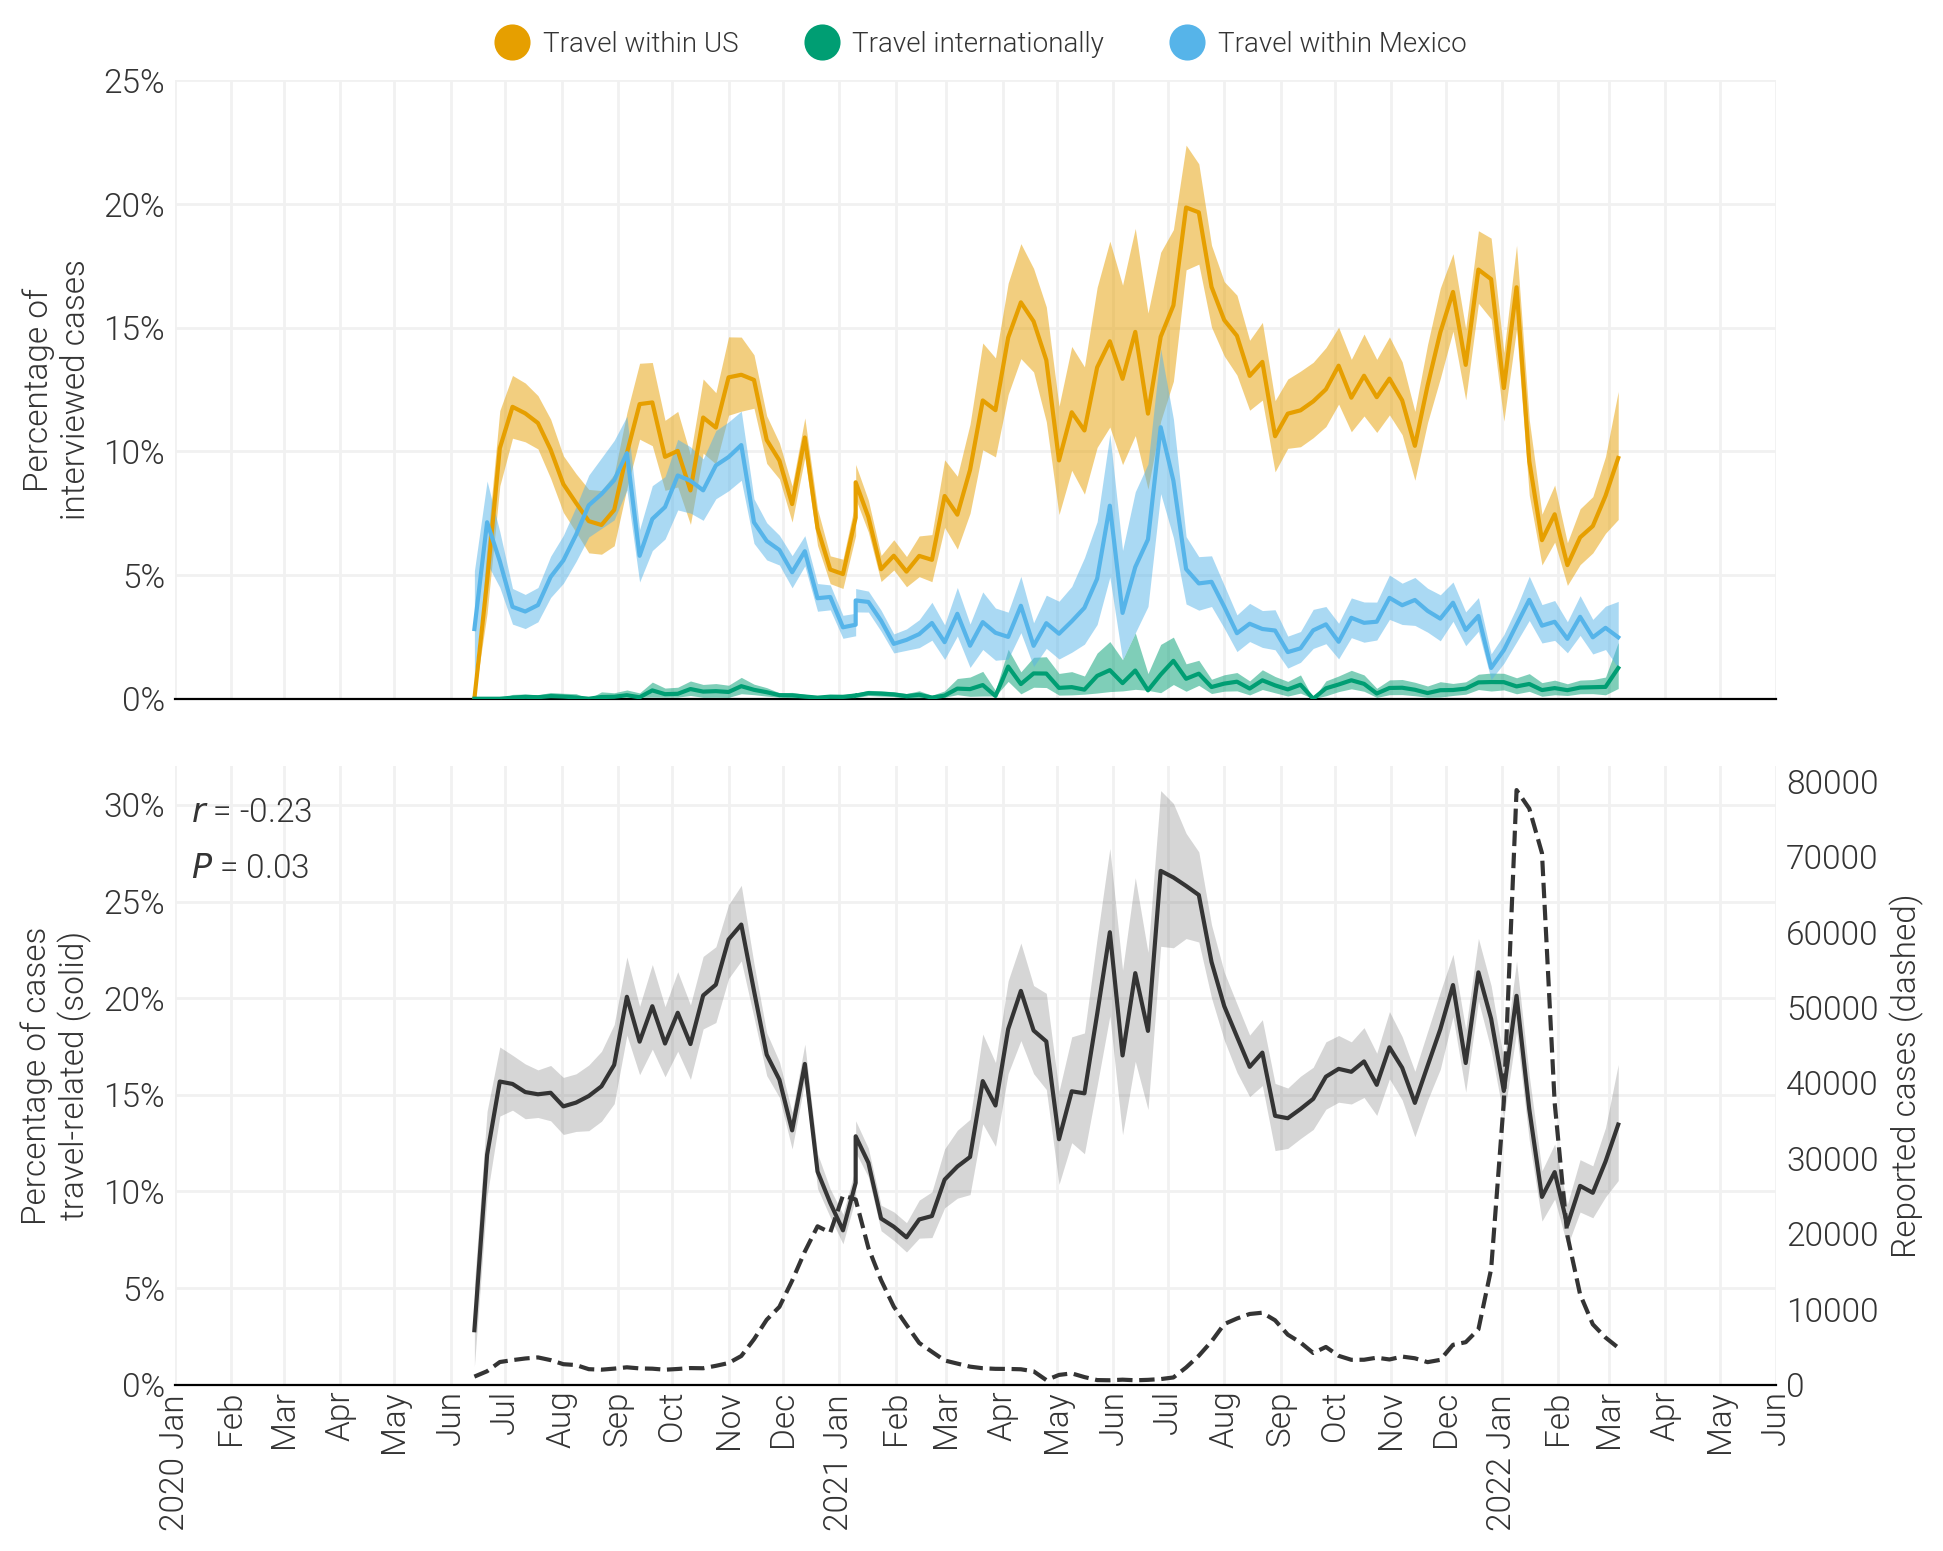

In [17]:
leg = []
fig, ax = plt.subplots( dpi=200, figsize=(10,8), nrows=2, sharex=True )
for loc, col in color_dict:
    plot_df = estimates.loc[estimates["source"]==loc]
    ax[0].plot( "date", "median", data=plot_df, color=col, zorder=9 )
    ax[0].fill_between( "date", "upper", "lower", data=plot_df, color=col, alpha=0.5, zorder=8, linewidth=0 )
    leg.append( Line2D([0], [0], linestyle='none', marker='o', color=col, label=name_dic[loc], markersize=12 ) )

ax[0].yaxis.set_major_formatter( PercentFormatter( 1, 0 ) )
basic_formatting(
    ax[0],
    which="both",
    spines=["bottom"],
    ylabel="Percentage of\ninterviewed cases",
    ylims=[0,0.25],
    xlims=[pd.to_datetime("2020-01-01"), pd.to_datetime("2022-06-01")]
)
timeseries_formatting( ax[0] )
ax[0].legend( handletextpad=0.1, handles=leg, frameon=False, fontsize=10, ncol=6, loc="upper center", bbox_to_anchor=(0,0,1,1.12) )
ax[0].label_outer()

ax[1].plot( "date", "median", data=total, color=COLOR, zorder=10 )
ax[1].fill_between( "date", "lower", "upper", data=total, color=COLOR, alpha=0.2, zorder=9, linewidth=0 )
ax2 = ax[1].twinx()
ax2.plot( total["week"], total["cases"] , color=COLOR, linestyle="dashed" )

basic_formatting( ax[1], spines=["bottom"], which="both", ylabel="Percentage of cases\ntravel-related (solid)", xlims=[pd.to_datetime("2020-01-01"), pd.to_datetime("2022-06-01")], ylims=(0, 0.32) )
ax[1].yaxis.set_major_formatter( PercentFormatter(1, decimals=0) )
[ax2.spines[j].set_visible( False ) for j in ax2.spines]
ax2.tick_params( axis="y", right=False, which="both", labelleft=False, pad=0, labelsize=12)
ax2.set_ylabel( "Reported cases (dashed)", fontsize=12 )
ax2.set_ylim(0,82000)

result = pearsonr( total["median"], total["cases"])
print( result )
print( result.confidence_interval() )
ax[1].text( 0.01, 0.95, f"$r$ = {result.statistic:.2f}", transform=ax[1].transAxes, fontsize=12, ha="left", va="top" )
ax[1].text( 0.01, 0.86, f"$P$ = {result.pvalue:.2f}", transform=ax[1].transAxes, fontsize=12, ha="left", va="top" )

timeseries_formatting(ax[1])

plt.tight_layout()
fig.savefig( "../analyses/plots/figureS10_contract-tracing-correlation.pdf" )
plt.show()


PearsonRResult(statistic=-0.23203513653414423, pvalue=0.02603812846927109)
ConfidenceInterval(low=-0.4170331110309487, high=-0.028575792333257452)


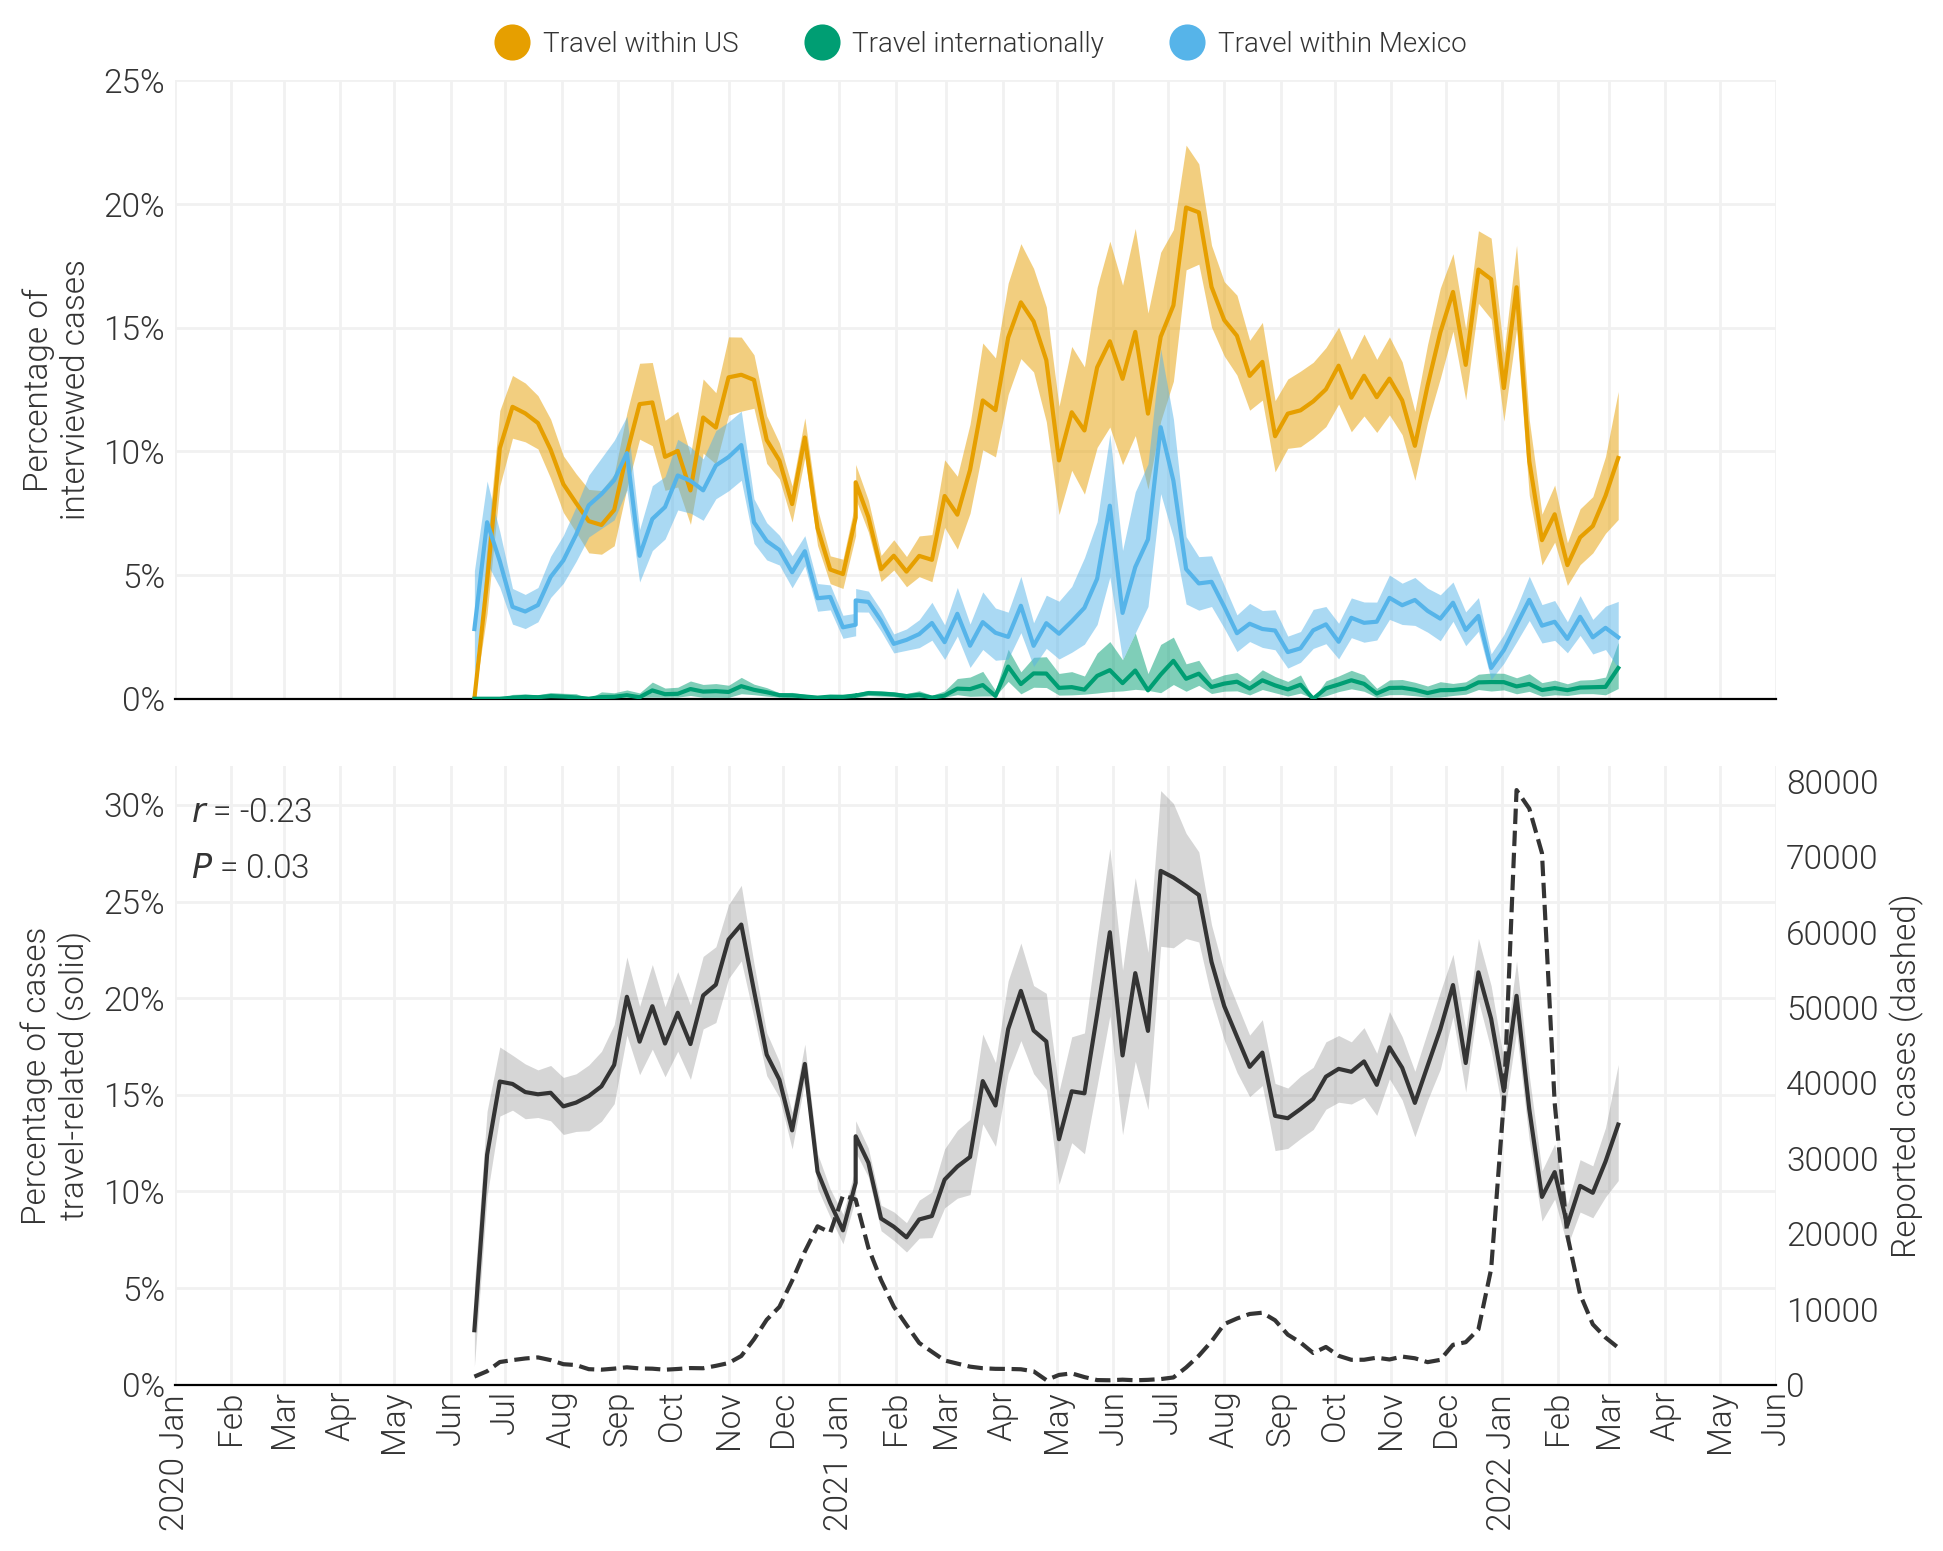

In [18]:
leg = []
fig, ax = plt.subplots( dpi=200, figsize=(10,8), nrows=2, sharex=True )
for loc, col in color_dict:
    plot_df = estimates.loc[estimates["source"]==loc]
    ax[0].plot( "date", "median", data=plot_df, color=col, zorder=9 )
    ax[0].fill_between( "date", "upper", "lower", data=plot_df, color=col, alpha=0.5, zorder=8, linewidth=0 )
    leg.append( Line2D([0], [0], linestyle='none', marker='o', color=col, label=name_dic[loc], markersize=12 ) )

ax[0].yaxis.set_major_formatter( PercentFormatter( 1, 0 ) )
basic_formatting(
    ax[0],
    which="both",
    spines=["bottom"],
    ylabel="Percentage of\ninterviewed cases",
    ylims=[0,0.25],
    xlims=[pd.to_datetime("2020-01-01"), pd.to_datetime("2022-06-01")]
)
timeseries_formatting( ax[0] )
ax[0].legend( handletextpad=0.1, handles=leg, frameon=False, fontsize=10, ncol=6, loc="upper center", bbox_to_anchor=(0,0,1,1.12) )
ax[0].label_outer()

ax[1].plot( "date", "median", data=total, color=COLOR, zorder=10 )
ax[1].fill_between( "date", "lower", "upper", data=total, color=COLOR, alpha=0.2, zorder=9, linewidth=0 )
ax2 = ax[1].twinx()
ax2.plot( total["week"], total["cases"] , color=COLOR, linestyle="dashed" )

basic_formatting( ax[1], spines=["bottom"], which="both", ylabel="Percentage of cases\ntravel-related (solid)", xlims=[pd.to_datetime("2020-01-01"), pd.to_datetime("2022-06-01")], ylims=(0, 0.32) )
ax[1].yaxis.set_major_formatter( PercentFormatter(1, decimals=0) )
[ax2.spines[j].set_visible( False ) for j in ax2.spines]
ax2.tick_params( axis="y", right=False, which="both", labelleft=False, pad=0, labelsize=12)
ax2.set_ylabel( "Reported cases (dashed)", fontsize=12 )
ax2.set_ylim(0,82000)

result = pearsonr( total["median"], total["cases"])
print( result )
print( result.confidence_interval() )
ax[1].text( 0.01, 0.95, f"$r$ = {result.statistic:.2f}", transform=ax[1].transAxes, fontsize=12, ha="left", va="top" )
ax[1].text( 0.01, 0.86, f"$P$ = {result.pvalue:.2f}", transform=ax[1].transAxes, fontsize=12, ha="left", va="top" )

timeseries_formatting(ax[1])

plt.tight_layout()

plt.show()
